Monthly average of CO2 and CH4 data used for this project is from NOAA Global Monitoring Laboratory "https://gml.noaa.gov/data/data.php"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# NOAA GML custom modules
from ccgvu import ccg_dates  # Date utilities
from ccgvu import ccg_filter  # Data filtering and curve fitting

In [2]:
#Read data
ch4_filename = "ch4_baltic.txt"
co2_filename = "co2_baltic.txt"
ch4_data = pd.read_table(ch4_filename, header=None, sep = r'\s+', skiprows=53)

co2_data = pd.read_table(co2_filename, header=None, sep = r'\s+', skiprows=53)

In [3]:
def read_header_file(filename):
    with open(filename, "r") as f:
        for line in f:
            if line.startswith("#") and "data_fields:" in line:
                cols = line.strip().split("data_fields:")[1].strip().split()
                break
    return cols

In [4]:
ch4_data.columns = read_header_file(ch4_filename)
co2_data.columns = read_header_file(co2_filename)



In [5]:
ch4_data = ch4_data.iloc[: , 1:]
co2_data = co2_data.iloc[: , 1:]


In [6]:
ch4_data["date"] = pd.to_datetime(dict(year=ch4_data.year, month=ch4_data.month, day = 1))
co2_data["date"] = pd.to_datetime(dict(year=co2_data.year, month=co2_data.month, day = 1))




In [7]:
data = co2_data.merge(ch4_data, on=["year", "month", "date"], how="inner")
data = data.sort_values("date")

data = data.iloc[:, [3, 0, 1, 2, 4]]  # 'Sr.no', 'Maths Score', 'Name'
data.columns = ["date", "year", "month", "co2", "ch4"]

In [8]:
data

,date,year,month,co2,ch4
0,1992-09-01,1992,9,353.17,1846.87
1,1992-10-01,1992,10,359.98,1853.50
2,1992-11-01,1992,11,361.21,1850.97
3,1992-12-01,1992,12,360.48,1832.20
4,1993-01-01,1993,1,362.70,1828.41
...,...,...,...,...,...
208,2011-02-01,2011,2,400.03,1921.64
209,2011-03-01,2011,3,401.30,1918.01
210,2011-04-01,2011,4,397.96,1898.30
211,2011-05-01,2011,5,396.36,1895.60


In [9]:
# add 2 columns using apply()
data["decimaltime"] = data.apply(lambda row: row["year"] + row["month"]/12, axis=1)

In [10]:
window_size = 6
ch4_data["emission_smoothed"] = ch4_data["value"].rolling(window=window_size).mean()
#co_data["emission_smoothed"] = co_data["value"].rolling(window=window_size).mean()
co2_data["emission_smoothed"] = co2_data["value"].rolling(window=window_size).mean()
#n2o_data["emission_smoothed"] = n2o_data["value"].rolling(window=window_size).mean()

<Figure size 640x480 with 0 Axes>

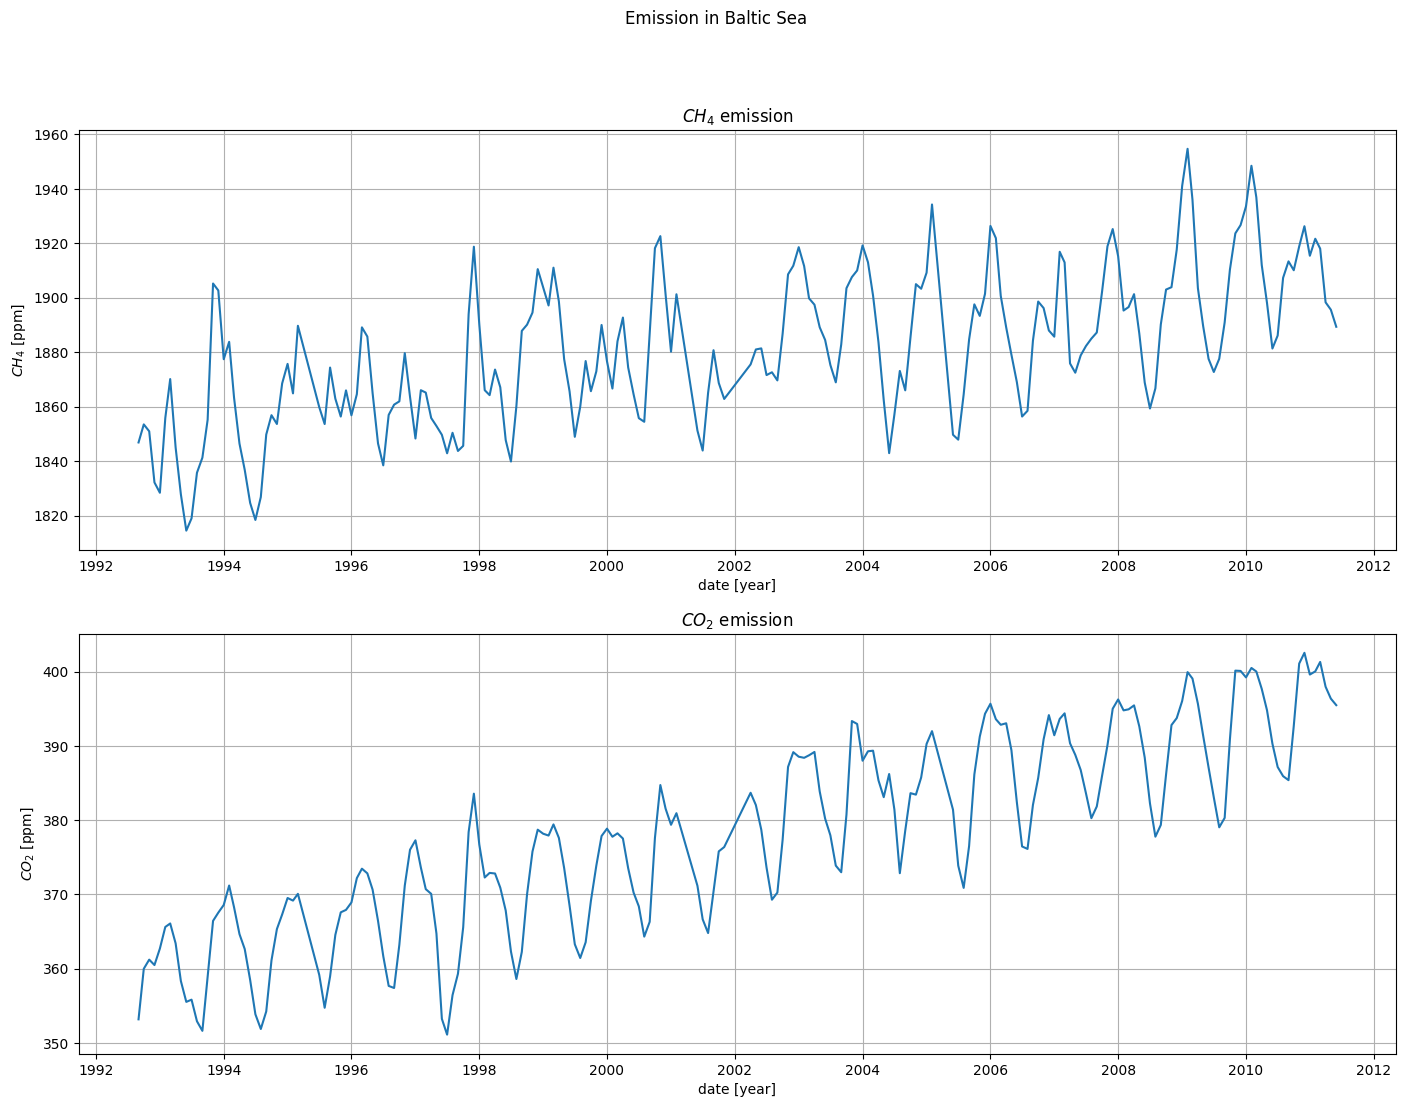

In [11]:
plt.figure()
fig,ax = plt.subplots(2, figsize=(17,12))
fig.suptitle("Emission in Baltic Sea")




ax[0].plot(data["date"], data["ch4"])
#ax[0].plot(ch4_data["date"], ch4_data["emission_smoothed"], label=f'Moving Average (Window={window_size})', color='black')
ax[0].set_xlabel("date [year]")
ax[0].set_ylabel("$CH_4$ [ppm]")
ax[0].set_title("$CH_4$ emission")
ax[0].grid()


ax[1].plot(data["date"], data["co2"])
#ax[1].plot(co2_data["date"], co2_data["emission_smoothed"], label=f'Moving Average (Window={window_size})', color='black')
ax[1].set_xlabel("date [year]")
ax[1].set_ylabel("$CO_2$ [ppm]")
ax[1].set_title("$CO_2$ emission")
ax[1].grid()



In [12]:
def apply_ccg_filter(xp, yp):
    # Create filter object using NOAA GML's curve fitting class
    filt = ccg_filter.ccgFilter(
        xp,  # Time values in decimal years
        yp,  # CO2 mole fraction values
        shortterm=80,        # Short term smoothing cutoff in days
        longterm=667,        # Long term trend cutoff in days
        # Interval for evenly spaced data (0 means use original spacing)
        sampleinterval=0,
        numpolyterms=3,      # Polynomial terms (quadratic)
        numharmonics=4,      # Number of harmonics for seasonal cycle
        timezero=-1,         # Reference time zero for polynomial fitting
        gap=0,               # No gap-filling in interpolation
        use_gain_factor=False,  # Disable gain factor in harmonics
        debug=False          # Disable debug messages
    )

    # Interpolated time grid
    x0 = filt.xinterp
    
    # Extract components
    smooth = filt.getSmoothValue(x0)
    trend = filt.getTrendValue(x0)
    seasonal = smooth - trend  # seasonal component
    
    # Convert to datetime
    dates = [ccg_dates.datetimeFromDecimalDate(x) for x in x0]
    
    # Build DataFrame
    df = pd.DataFrame({
        "date": dates,
        f"smooth": smooth,
        f"trend": trend,
        f"seasonal": seasonal
    })
    
    return df
    return filt

In [13]:
co2_df = apply_ccg_filter(data["decimaltime"], data["co2"])
ch4_df = apply_ccg_filter(data["decimaltime"], data["ch4"])

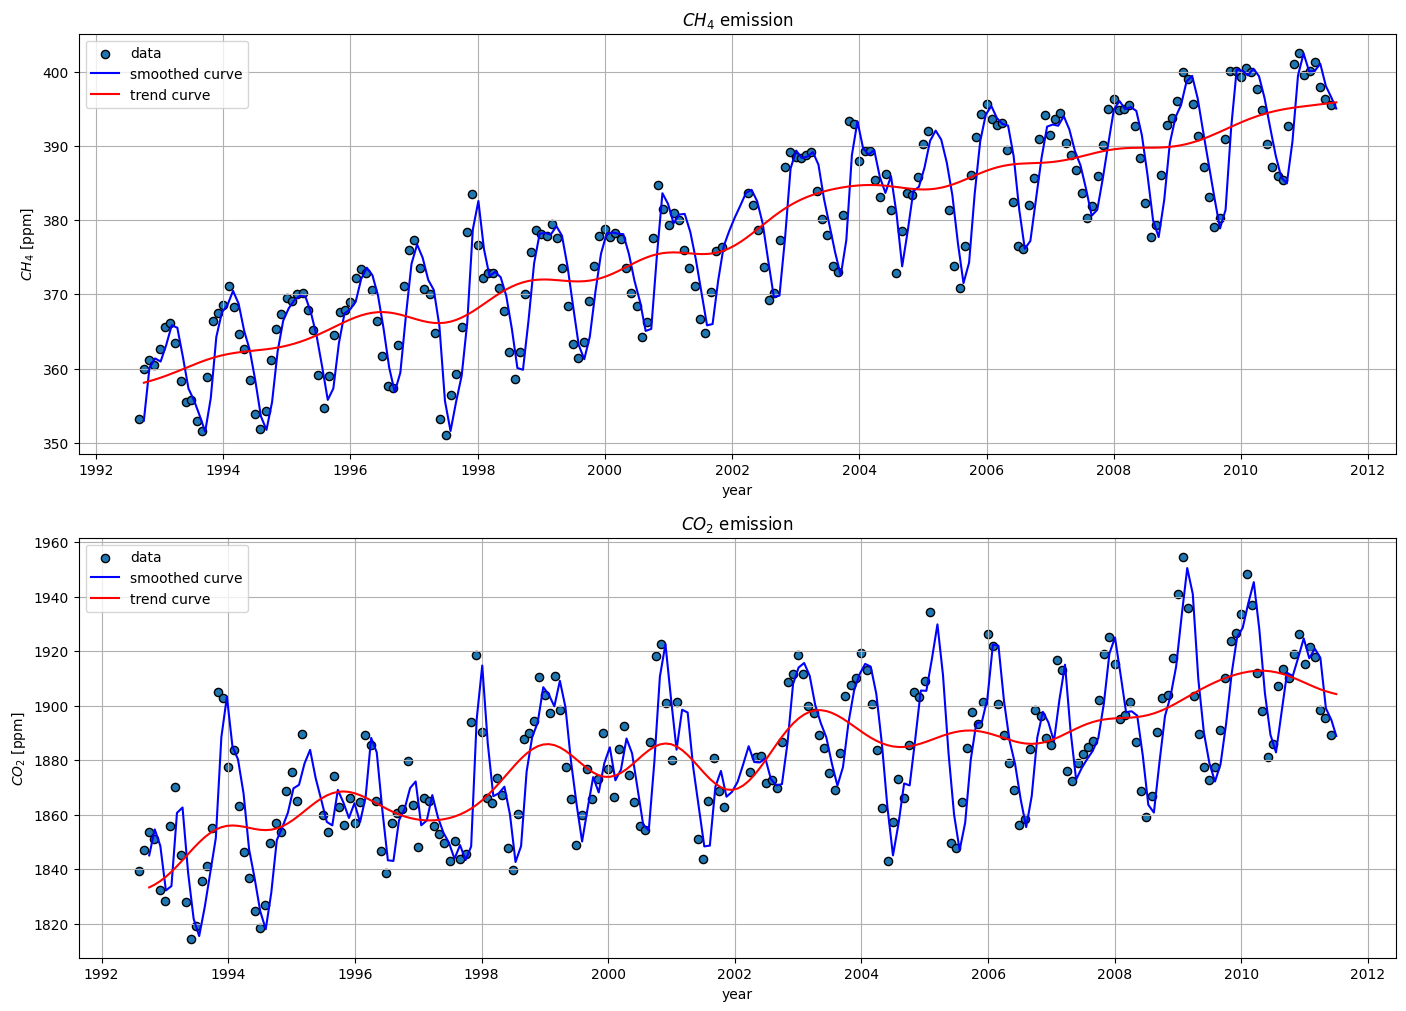

In [21]:
fig,ax = plt.subplots(2, figsize=(17,12))


ax[0].scatter(co2_data["date"], co2_data["value"], s=35, edgecolors= "black", label = "data")
ax[0].plot(co2_df["date"], co2_df["smooth"], c="blue", label= "smoothed curve")
ax[0].plot(co2_df["date"], co2_df["trend"], c="red", label = "trend curve")
ax[0].set_xlabel("year")
ax[0].set_ylabel("$CH_4$ [ppm]")
ax[0].set_title("$CH_4$ emission")
ax[0].grid()
ax[0].legend()

ax[1].scatter(ch4_data["date"], ch4_data["value"], s=35, edgecolors= "black", label = "data")
ax[1].plot(ch4_df["date"], ch4_df["smooth"], c="blue", label = "smoothed curve")
ax[1].plot(ch4_df["date"], ch4_df["trend"], c="red", label = "trend curve")
ax[1].set_xlabel("year")
ax[1].set_ylabel("$CO_2$ [ppm]")
ax[1].set_title("$CO_2$ emission")
ax[1].grid()
ax[1].legend()



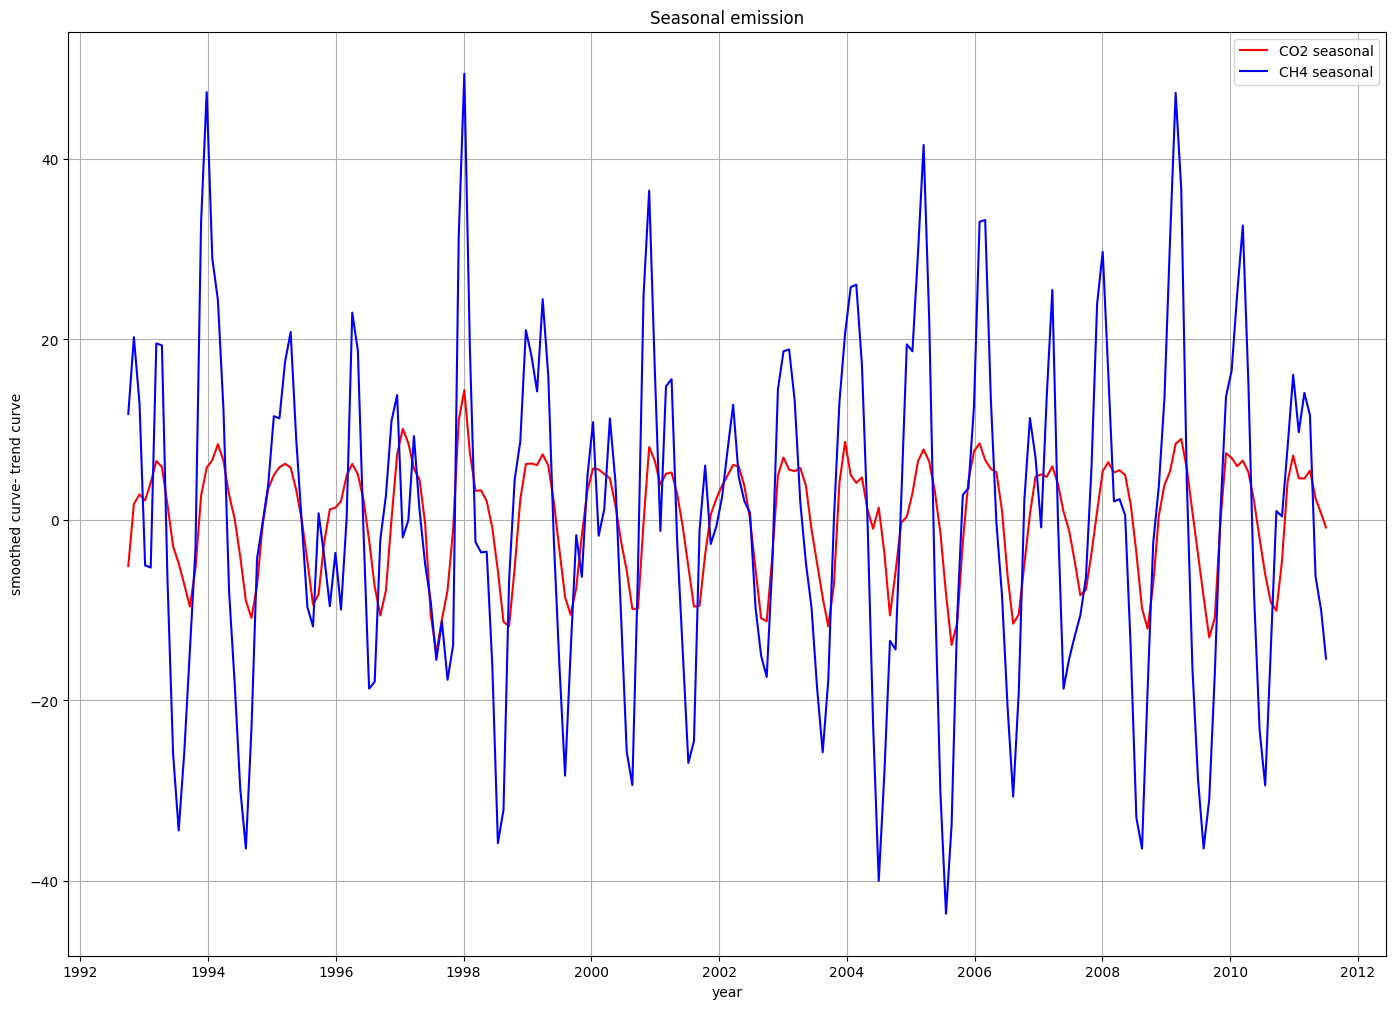

In [23]:
plt.figure(figsize=(17,12))

plt.plot(co2_df["date"], co2_df["seasonal"], c="red", label="CO2 seasonal")
plt.plot(ch4_df["date"], ch4_df["seasonal"], c="blue", label = "CH4 seasonal")
plt.title("Seasonal emission")
plt.xlabel("year")
plt.ylabel("smoothed curve- trend curve")
plt.grid()
plt.legend()

In [31]:
corr = co2_df["smooth"].corr(ch4_df["smooth"])
print("Pearson correlation:", corr)

Pearson correlation: 0.8291906560008923


In [33]:
trend_corr = co2_df["trend"].corr(ch4_df["trend"])
print("Pearson correlation:", trend_corr)

Pearson correlation: 0.9431470582856271


In [35]:
seasonal_corr = co2_df["seasonal"].corr(ch4_df["seasonal"])
print("Pearson correlation:", seasonal_corr)

Pearson correlation: 0.7357471178331617
